# PvP playout analysis

In [45]:
import sys
import os

project_root = os.path.abspath('../../')
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_formats = ['svg']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## MCTS bots

In [50]:
from catan.analysis.plot_utils import plot_action_freqs
from catan.bots.mcts_bot import MCTSBot
from catan.core.game import Game
from catan.core.models.enums import ActionType
from catan.core.models.player import Color, RandomPlayer
from catan.bots.mcts_utils import pretty_print_mcts_tree
from catan.bots.mcts import MCTSNode

game = Game(
    players=[
        RandomPlayer(color=Color.RED, is_bot=True),
        MCTSBot(color=Color.BLUE, n_simulations=10),
    ]
)
game.play()



Move 0: MCTS bot performed action Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.BUILD_SETTLEMENT: 'BUILD_SETTLEMENT'>, value=3)
Move 0: MCTS bot performed action Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.BUILD_ROAD: 'BUILD_ROAD'>, value=(2, 3))
Move 2: MCTS bot performed action Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.BUILD_SETTLEMENT: 'BUILD_SETTLEMENT'>, value=7)
Move 2: MCTS bot performed action Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.BUILD_ROAD: 'BUILD_ROAD'>, value=(7, 8))
Move 2: MCTS bot performed action Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.ROLL: 'ROLL'>, value=None)
Move 2: MCTS bot performed action Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.END_TURN: 'END_TURN'>, value=None)
Move 4: MCTS bot performed action Action(color=<Color.BLUE: 'BLUE'>, action_type=<ActionType.ROLL: 'ROLL'>, value=None)
Move 4: MCTS bot performed action Action(color=<Color.BLUE: 'BLUE'>, action_type=<

<Color.BLUE: 'BLUE'>

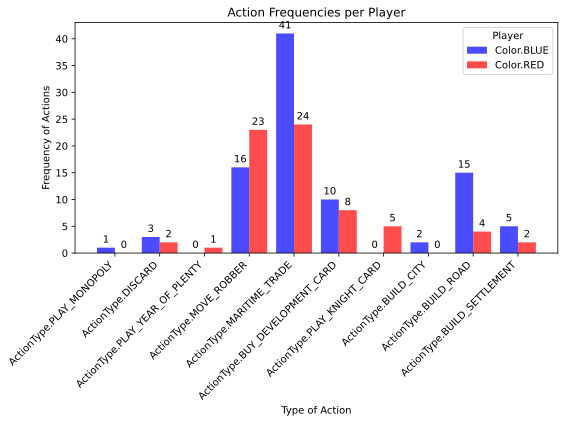

In [51]:
_, _ = plot_action_freqs(
    game.state.actions,
    exclusions=[ActionType.ROLL, ActionType.END_TURN]
)

In [52]:
from catan.analysis.player_stats import player_stats, print_player_stats


stats = player_stats(game)
print_player_stats(stats)

[PlayerStats(color=<Color.BLUE: 'BLUE'>,
             player_type='MCTSBot',
             victory_points=10,
             longest_road=8,
             settlements=[15, 26, 28],
             n_settlements=3,
             roads=[(2, 3), (7, 8), (2, 9), (3, 4), (4, 15), (15, 17), (17, 39),
                    (38, 39), (37, 38), (14, 15), (8, 27), (26, 27), (27, 28),
                    (1, 2), (13, 14)],
             n_roads=15,
             cities=[7, 3],
             n_cities=2),
 PlayerStats(color=<Color.RED: 'RED'>,
             player_type='RandomPlayer',
             victory_points=5,
             longest_road=2,
             settlements=[19, 13],
             n_settlements=2,
             roads=[(19, 20), (12, 13), (0, 20), (13, 34)],
             n_roads=4,
             cities=[],
             n_cities=0)]


### MCTS Debug

In [44]:
debug_game = Game(
    players=[
        RandomPlayer(color=Color.RED, is_bot=True),
        MCTSBot(color=Color.BLUE),
    ]
)
mcts_root = MCTSNode(game=debug_game, color=Color.RED)
mcts_root.run_playouts(n_simulations=1)
best_action = mcts_root.find_best_action()


pretty_print_mcts_tree(
    root_node=mcts_root,
    max_depth=100
)


MCTS Root (P(RED) perspective) [Total W/V: 1/1] (Current Turn: P(N/A))
└── Act: P(RED): BUILD_SETTLEMENT(4) [W/V: 1/1 for P(RED), UCB1: 1.0] (Turn: P(N/A)) (Leaf - Not Fully Expanded)
